In [1]:
import numpy as np

import cv2

import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

from skimage.feature import hog

from sklearn.preprocessing import StandardScaler

# from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC

from scipy.ndimage.measurements import label

import pickle

import glob

from random import shuffle

import os

import time

import math

from tqdm import tqdm

from moviepy.editor import VideoFileClip

In [2]:
cars = glob.glob('x:/XCar/detection_data/vehicles/**/*.png', recursive=True)
notcars = glob.glob('x:/XCar/detection_data/non-vehicles/**/*.png', recursive=True)

print('len(cars)', len(cars))
print('len(notcars)', len(notcars))
print(cars[1])
    
print(cars[0:4])

len(cars) 8792
len(notcars) 8968
x:/XCar/detection_data/vehicles\GTI_Far\image0001.png
['x:/XCar/detection_data/vehicles\\GTI_Far\\image0000.png', 'x:/XCar/detection_data/vehicles\\GTI_Far\\image0001.png', 'x:/XCar/detection_data/vehicles\\GTI_Far\\image0002.png', 'x:/XCar/detection_data/vehicles\\GTI_Far\\image0003.png']


In [3]:
shuffle(cars)
shuffle(notcars)
print("shuffled")

shuffled


Total Number of Vehicle Images: 8792
Total Number of Non-Vehicle Images: 8968
Image Size: (64, 64, 3)
Image Type: float32


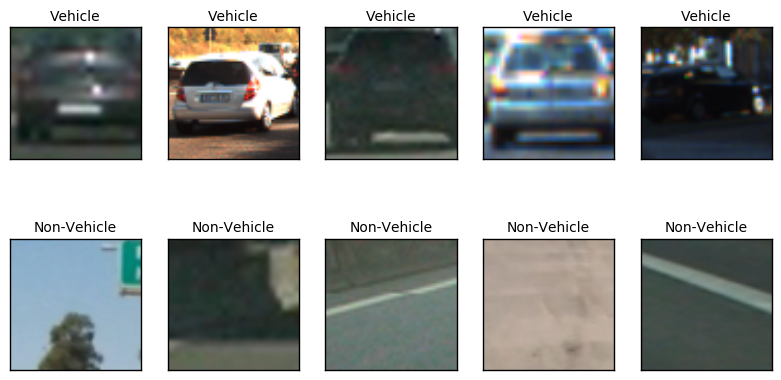

In [4]:
def visualize_data(cars, not_cars):
    data_dict = {}
    data_dict["n_cars"] = len(cars)
    data_dict["n_not_cars"] = len(not_cars)
    img = mpimg.imread(cars[0])
    data_dict["img_shape"] = img.shape
    data_dict["d_type"] = img.dtype
    return data_dict

visual = visualize_data(cars, notcars)  

print('Total Number of Vehicle Images: {0}'.format(visual['n_cars']))
print('Total Number of Non-Vehicle Images: {0}'.format(visual['n_not_cars']))

print('Image Size: {0}\nImage Type: {1}'.format(visual['img_shape'], visual['d_type']))

def random_image(cars, not_cars):
    car_id = np.random.randint(0, len(cars))
    not_car_id = np.random.randint(0, len(not_cars))
    car_image = mpimg.imread(cars[car_id])
    not_car_image = mpimg.imread(not_cars[not_car_id])
    return car_image, not_car_image

n = 0
fig = plt.figure(figsize=(20, 10))
while n < 5:
    car_image, not_car_image = random_image(cars, notcars)
    fig.add_subplot(1, 10, n+1)
    plt.imshow(not_car_image)
    plt.xticks(()); 
    plt.yticks(());    
    plt.title('Non-Vehicle', fontsize=10)
    fig.add_subplot(2, 10, n+1)
    plt.imshow(car_image)
    plt.xticks(()); plt.yticks(());    
    plt.title('Vehicle', fontsize=10)
    n += 1
plt.savefig('output_images/data_visualization.png', bbox_inches="tight")

In [5]:
car_id = np.random.randint(0, len(cars))
print ('car_id ',car_id)
car_id = np.random.randint(0, len(cars))
rand_img = cv2.imread(cars[car_id])
rand_img = cv2.cvtColor(rand_img, cv2.COLOR_BGR2RGB)
rand_img.shape

car_id  8428


(64, 64, 3)

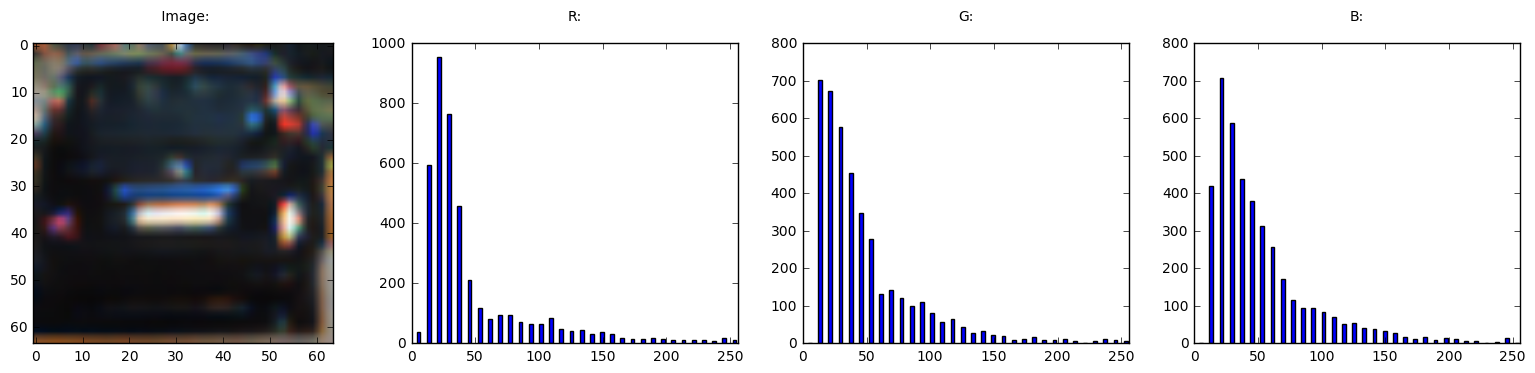

In [6]:
#visulize histogram

red_hist = np.histogram(rand_img[:,:,0], bins=32, range=(0, 256))
green_hist = np.histogram(rand_img[:,:,1], bins=32, range=(0, 256))
blue_hist = np.histogram(rand_img[:,:,2], bins=32, range=(0, 256))
hist_features = np.concatenate((red_hist[0], green_hist[0], blue_hist[0]))

bin_edges = red_hist[1] #all three bins are the same size
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1])/2

fig = plt.figure(figsize=(10,3));
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)

plt.subplot(1, 4, 1)
plt.imshow(rand_img)
plt.title(' Image:\n', fontsize=10);

plt.subplot(1, 4, 2)
plt.bar(bin_centers, red_hist[0], width=3)
plt.xlim(0, 256)
plt.title('R:\n', fontsize=10);

plt.subplot(1, 4, 3)
plt.bar(bin_centers, green_hist[0], width=3)
plt.xlim(0, 256)
plt.title('G:\n', fontsize=10);

plt.subplot(1, 4, 4)
plt.bar(bin_centers, blue_hist[0], width=3)
plt.xlim(0, 256)
plt.title('B:\n', fontsize=10);

plt.subplots_adjust(left=0.5, right=2, top=1, bottom=0.)
plt.savefig('output_images/histograms_color_visualization.png', 
            bbox_inches="tight")

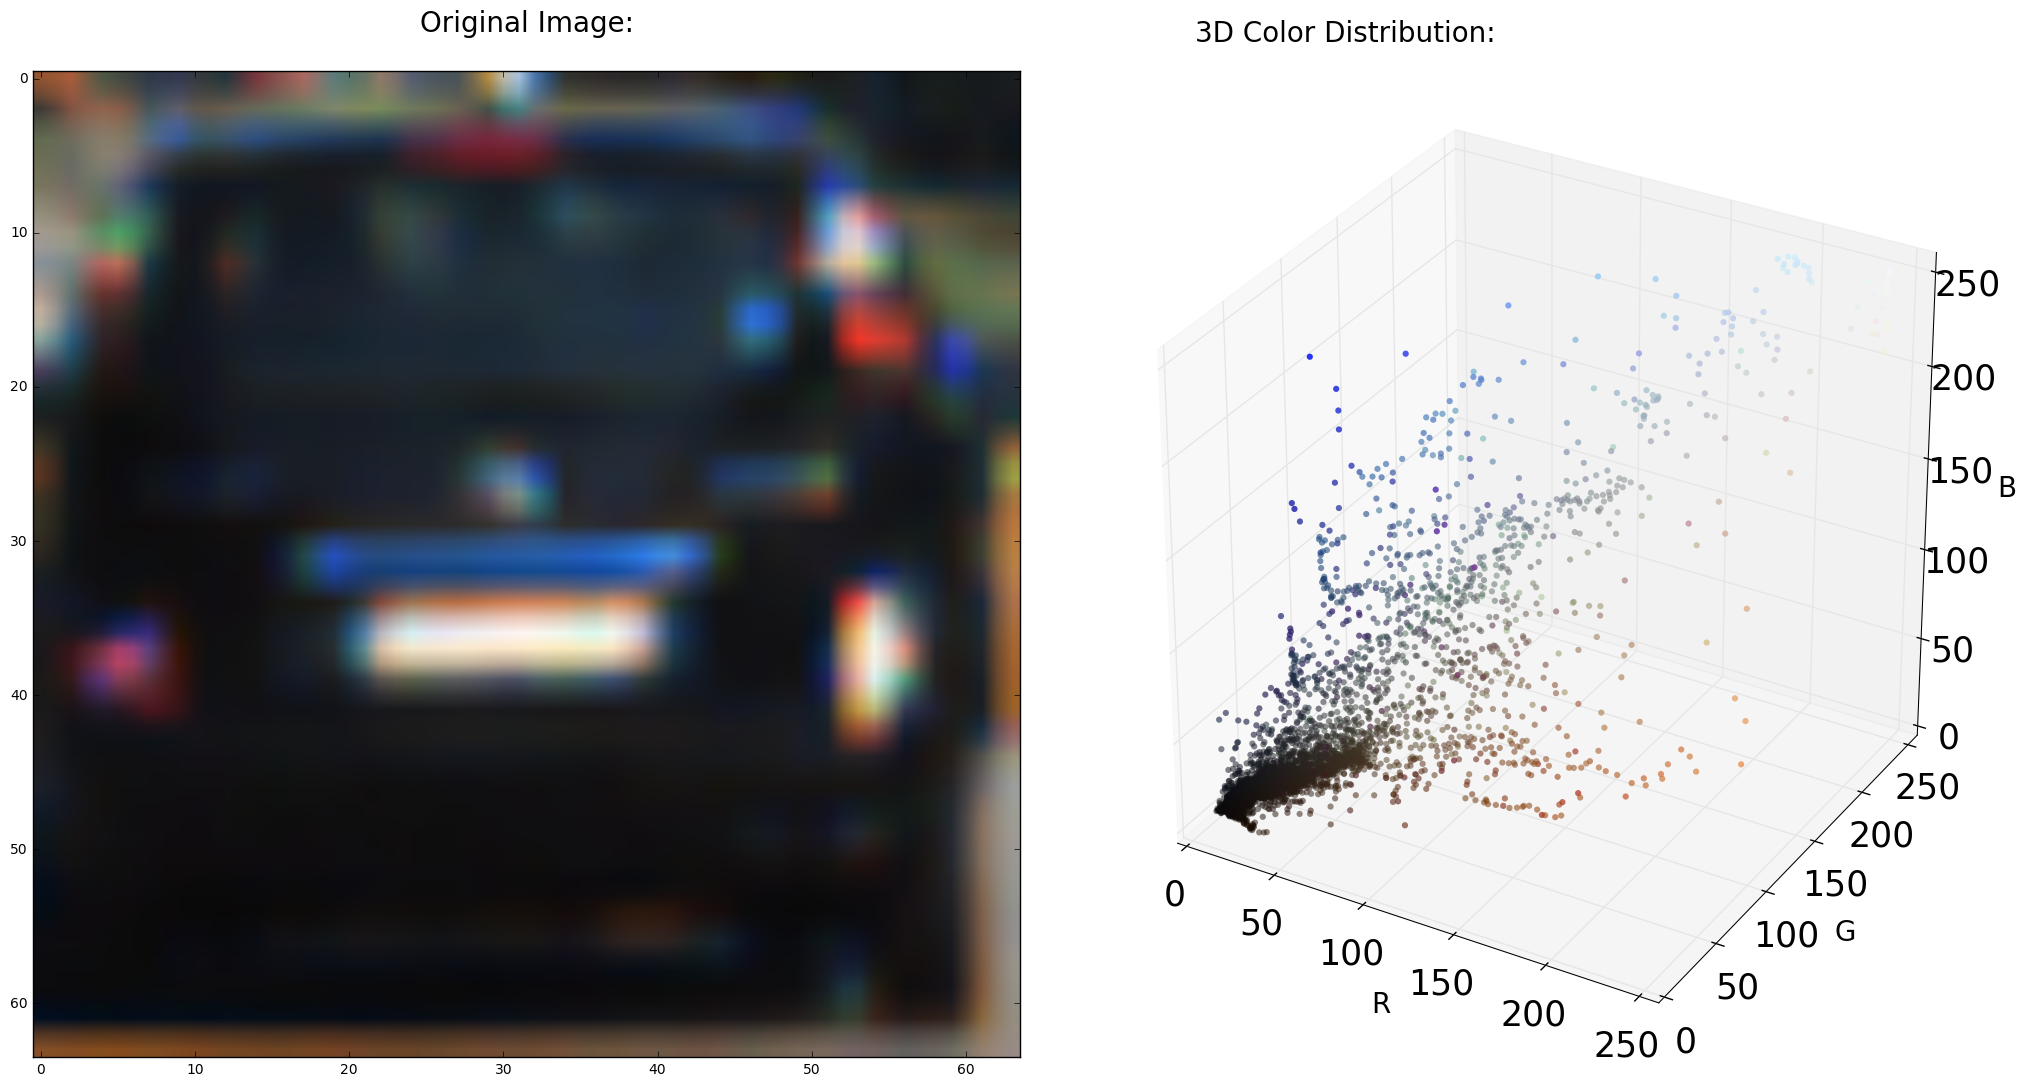

In [7]:
##color distribution

scale = max(rand_img.shape[0], rand_img.shape[1], 64) / 64
img_small = cv2.resize(rand_img, (np.int(rand_img.shape[1] / scale),
                                  np.int(rand_img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.

pixels = img_small_RGB
colors_rgb = img_small_rgb
axis_labels = list('RGB')
axis_limits = [(0,255), (0,255), (0,255)]

f = plt.figure(figsize=(20,10));
ax1 = f.add_subplot(1, 2, 1);
f.tight_layout()
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
ax1.imshow(rand_img)
ax1.set_title('Original Image:\n', fontsize=20);

ax2 = f.add_subplot(1, 2, 2, projection='3d');
ax2.text2D(0.15, 0.99, "3D Color Distribution:\n", 
           transform=ax2.transAxes, fontsize=20)

ax2.set_xlim(*axis_limits[0])
ax2.set_ylim(*axis_limits[1])
ax2.set_zlim(*axis_limits[2])

ax2.tick_params(axis='both', which='major', labelsize=25, pad=8)
ax2.set_xlabel(axis_labels[0], fontsize=20, labelpad=20)
ax2.set_ylabel(axis_labels[1], fontsize=20, labelpad=20)
ax2.set_zlabel(axis_labels[2], fontsize=20, labelpad=20)

ax2.scatter(pixels[:,:,0].ravel(), pixels[:,:,1].ravel(), 
            pixels[:,:,2].ravel(), c=colors_rgb.reshape((-1, 3)), 
            edgecolors='none');

plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
plt.savefig('output_images/color_distribution_visualization.png', 
            bbox_inches="tight")

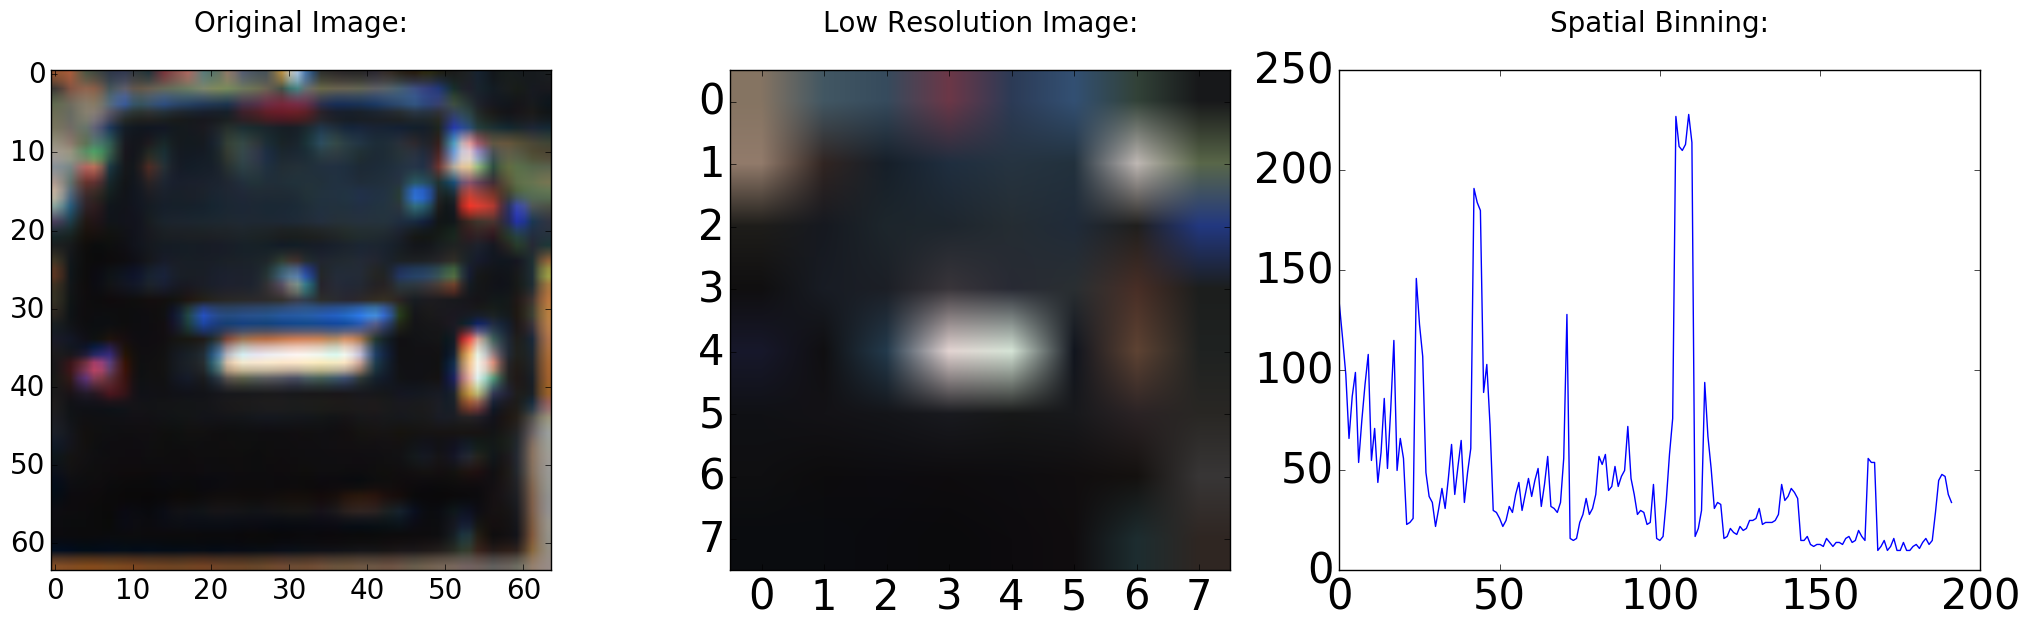

In [8]:
#visualize features

# color_space = 'RGB'
color_space = 'RGB'
size = (8, 8)

small_img = cv2.resize(rand_img, size)

if color_space != 'RGB':
    if color_space == 'HSV':
        feature_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2YCrCb)
else: 
    feature_img = np.copy(rand_img)             
features = cv2.resize(feature_img, size).ravel() 

f = plt.figure(figsize=(20, 5));
ax1 = f.add_subplot(1, 3, 1);
f.tight_layout()
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)
ax1.imshow(rand_img)
ax1.set_title('Original Image:\n', fontsize=20);

ax2 = f.add_subplot(1, 3, 2);
ax2.imshow(small_img)
ax2.set_title('Low Resolution Image:\n', fontsize=20);

ax3 = f.add_subplot(1, 3, 3);
ax3.plot(features)
ax3.set_title('Spatial Binning:\n', fontsize=20);

plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
plt.savefig('output_images/spatial_binning_RGB.png', 
            bbox_inches="tight")

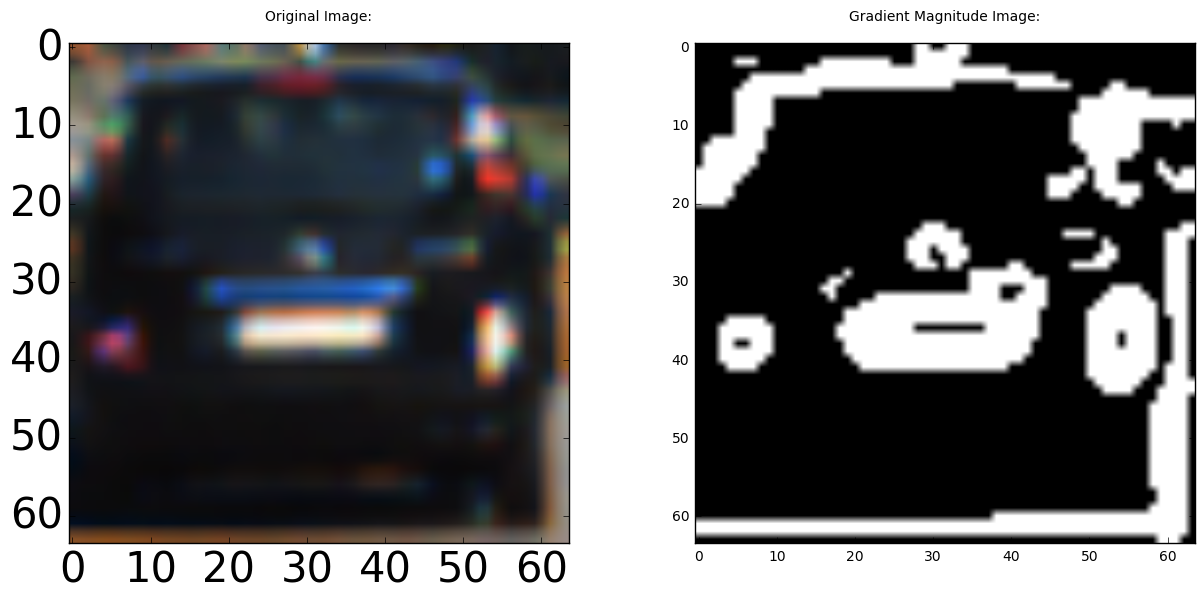

In [9]:
###gradient feature

gray = cv2.cvtColor(rand_img, cv2.COLOR_RGB2GRAY)
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=9)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=9)
gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
scale_factor = np.max(gradmag)/255 
gradmag = (gradmag/scale_factor).astype(np.uint8) 
binary_output = np.zeros_like(gradmag)
binary_output[(gradmag >= 50) & (gradmag <= 255)] = 1

f = plt.figure(figsize=(12, 5));
ax1 = f.add_subplot(1, 2, 1);
f.tight_layout()
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
ax1.imshow(rand_img)
ax1.set_title('Original Image:\n', fontsize=10);

ax2 = f.add_subplot(1, 2, 2);
ax2.imshow(binary_output, cmap='gray')
ax2.set_title('Gradient Magnitude Image:\n', fontsize=10);

plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
plt.savefig('output_images/gradient_visualization.png', bbox_inches="tight")

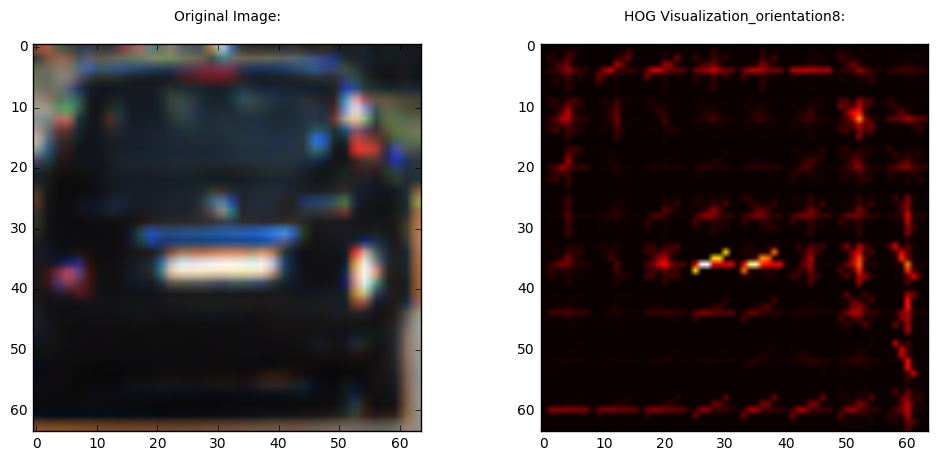

In [18]:
##HOG
hog_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2GRAY)

features, hog_image = hog(hog_img, 
                          orientations=8, 
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          visualise=True,
                          feature_vector=False)

fig = plt.figure(figsize=(12, 5));
fig.add_subplot(1, 2, 1)
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
plt.imshow(rand_img)
plt.title('Original Image:\n', fontsize=10);
fig.add_subplot(1, 2, 2)
plt.imshow(hog_image, cmap='hot')
plt.title('HOG Visualization_orientation8:\n', fontsize=10);
plt.savefig('output_images/hog_visualization_Orent8.png', bbox_inches="tight")